In [1]:
import os
import gc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta

import tensorflow as tf

parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)
from utils.helper import fn_plot_tf_hist

In [2]:
PATIENCE = 20
LR_FACTOR = .2
LR_PATIENCE = 5
BUFFER_SIZE = 10000

In [3]:
inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = os.path.join('..', 'model')
subDir = os.path.join('text_gen')
fileName = 'shakespeare.txt'

EPOCHS = 30
ALPHA = .001
TEST_SIZE = .2  


BATCH_SIZE = 64 # default batch size fot tf
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.RandomState(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE) ######

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

## define data


In [5]:
filePath = os.path.join(inpDir, subDir, fileName)

In [6]:
text = open(filePath, 'rb').read().decode(encoding = 'utf-8') #The decode method in the context of bytes objects in Python is used to convert a byte sequence (binary data) into a string using a specific character encoding. 

len(text)

1115395

In [7]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## character base modelling

In [9]:
vocab = sorted(set(text)) #  A sorted list of unique characters in the text.
len(vocab) # all the characters  used in text file

65

In [116]:
# using vocab as character not as sentances or words because then the model will become too big to run on this machine

In [10]:
char2idx = {u: i for i, u in enumerate(vocab)} # dict of index of character with character being key

idx2char = np.array(vocab) # in array i can refer element by idx

In [11]:
text_as_int = np.array([char2idx [c] for c in text]) # will  have all sequence of integer which are index of those chars in `idx2char`
text_as_int.shape

(1115395,)

In [12]:
display(type(text_as_int))
idx2char[text_as_int[0]]

numpy.ndarray

'F'

In [13]:
seq_length = 100 # how many character will the data will work at a time

example_per_epoch = len(text) // (seq_length + 1)
# examples_per_epoch tells us how many training sequences can be created from the given text, based on the defined sequence length (seq_length).

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(20): #Prints the first 20 characters from the dataset along with their indices.
    print(i.numpy(), end = ' : ')
    print(idx2char[i.numpy()])
    

18 : F
47 : i
56 : r
57 : s
58 : t
1 :  
15 : C
47 : i
58 : t
47 : i
64 : z
43 : e
52 : n
10 : :
0 : 

14 : B
43 : e
44 : f
53 : o
56 : r


In [14]:
sequences = char_dataset.batch(seq_length+1, drop_remainder = True)# Groups the dataset into sequences of length seq_length + 1 (100+1 in this case).
# drop_remainder=True ensures only complete sequences are included.

for item in sequences.take(2):
    print(item)
    print(repr(''.join(idx2char[item.numpy()])))

tf.Tensor(
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1], shape=(101,), dtype=int32)
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
tf.Tensor(
[39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39 58 46 43 56  1
 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47 57 46 12  0  0
 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53 50 60 43 42  8
  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47 56 57 58  6  1
 63 53 59  1 49], shape=(101,), dtype=int32)
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'


In [15]:
len(sequences)

11043

In [16]:
def split_input_target(chunk):
    input_text = chunk[:-1] # first hundred characters
    target_text = chunk[1:] # offset one as target
    return input_text, target_text
# Splits each sequence of length 101 into:
# Input: First 100 characters.
# Target: Next 100 characters (used as the target for prediction).
dataset = sequences.map(split_input_target)

In [17]:
# The repr function in Python returns a string representation of an object that is designed to be unambiguous.

In [18]:
for inp_ex, tar_ex in dataset.take(2):
    print(repr(''.join(idx2char[inp_ex.numpy()])))
    print(repr(''.join(idx2char[tar_ex.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you '
're all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'


#### preprocessing and fetching

In [20]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,
                                             drop_remainder = True)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int32, name=None), TensorSpec(shape=(64, 100), dtype=tf.int32, name=None))>

In [21]:
vocab_size = len(vocab)
embedding_dim = 256 # generally 2 ^ (power) embedding works better
rnn_unit = 1024


## preparing model

In [23]:
def build_model(vocab_size,
                embedding_dim,
                rnn_units,
                batch_size = BATCH_SIZE):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape = (None, ), batch_size = batch_size),
        
        tf.keras.layers.Embedding(vocab_size, embedding_dim),

        tf.keras.layers.GRU(rnn_units, return_sequences = True,
                           stateful = True,
                          recurrent_initializer = 'glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])

In [24]:
model = build_model(vocab_size, embedding_dim, rnn_unit, batch_size = BATCH_SIZE)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, None, 256)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, None, 1024)       │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, None, 65)         │        66,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,021,569 (15.34 MB)

 Trainable params: 4,021,569 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:
# (batch_size, sequence_length, embedding_dim/rnn_units/vocab_size)
# --batch_size: The number of sequences in a batch.
# --sequence_length: Length of each input sequence.
# --embedding_dim: Size of the embedding vector (e.g., 256).
# rnn_units: Number of GRU units (e.g., 1024).
# vocab_size: Predicts the probability for each character in the vocabulary.

#### unit testing

In [26]:
# Unit testing:~ checkin gif the model is working or not
for inp_ex, tar_ex in dataset.take(1):
    ex_pred = model(inp_ex)

In [27]:
ex_pred.shape # 64: batch size, 100: time step, : 

TensorShape([64, 100, 65])

In [28]:
### why we sample

In [29]:
sample_indices = tf.random.categorical(ex_pred[0], num_samples = 1)
print(sample_indices.shape)

(100, 1)


In [30]:
sample_indices = tf.squeeze(sample_indices, axis = -1).numpy()

In [31]:
sample_indices.shape

(100,)

In [32]:
display(sample_indices)
print(repr(''.join(idx2char[sample_indices])))

array([ 6,  7, 41, 15, 39, 39, 10, 36, 52, 19, 31, 43, 61, 16, 49,  3, 44,
        7,  5, 30, 43, 14, 16, 36, 21, 61, 53, 25, 64, 49, 53, 60, 27, 48,
       45, 35, 12, 53, 38, 26, 12, 35, 49,  1, 27, 58, 23, 59, 10, 15,  5,
       46, 43, 48, 57, 23, 60, 15, 32, 53, 21,  8,  1, 55, 52, 27, 56, 59,
       48, 55, 57,  0, 16, 48, 20, 36, 22, 55, 21, 55, 23, 30, 15, 32,  0,
       50, 23,  4, 46, 45, 63, 28,  3,  5, 56, 64, 11, 57, 43,  4],
      dtype=int64)

",-cCaa:XnGSewDk$f-'ReBDXIwoMzkovOjgW?oZN?Wk OtKu:C'hejsKvCToI. qnOrujqs\nDjHXJqIqKRCT\nlK&hgyP$'rz;se&"


### training model

In [34]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits = True)
model.compile (optimizer = 'adam',
               loss = loss_fn,
               metrics = ['accuracy'])

In [35]:
chkPath = os.path.join(modelDir, subDir)
chkPtPrefix = os.path.join(chkPath, 'chkpt_{epoch}.keras') # chkPtPrefix: telling how you should make name of the file i save

chkpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath = chkPtPrefix ,)

In [36]:
history = model.fit(dataset, epochs = EPOCHS,
                    callbacks = [chkpt_callback],
                    verbose = 1)

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.2426 - loss: 3.0932
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.4394 - loss: 1.9109
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.5141 - loss: 1.6391
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5504 - loss: 1.5009
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.5697 - loss: 1.4233
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5843 - loss: 1.3643
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.5943 - loss: 1.3232
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.6039 - loss: 1.2862
Epoch 9/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 170s 981ms/step - accuracy: 0.6148 - loss: 1.2477
Epoch 10/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 170s 981ms/step - accuracy: 0.6239 - loss: 1.2135
Epoch 11/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 171s 984ms/step - accuracy: 0.6324 - loss: 1.1834
Epoch 12/30
172/172 ━━━━━━━━━━━━

In [37]:
loss_df = pd.DataFrame(history.history)

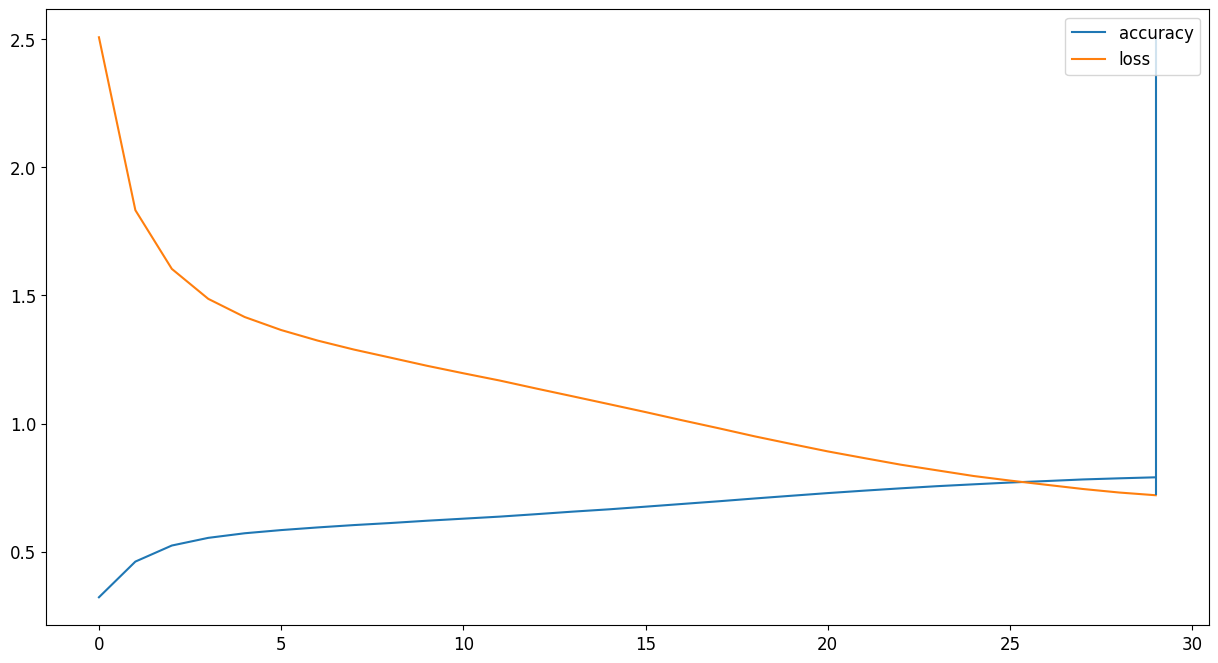

In [44]:
ax = loss_df.plot()
ax.vlines(loss_df.loc[loss_df['loss'] == loss_df['loss'].min()].index, ymin = loss_df.loc[loss_df['loss'] == loss_df['loss'].min()].values[0][1],
         ymax = loss_df.loc[loss_df['loss'] == loss_df['loss'].max()].values[0][1])

In [46]:
loss_df.loc[loss_df['loss'] == loss_df['loss'].min()]

,accuracy,loss
29,0.790134,0.72012


In [ ]:
 #!ls: Lists the contents of the current directory or a specified path. 

In [88]:
!dir {chkPath}

 Volume in drive C is OS
 Volume Serial Number is 4271-C479

 Directory of C:\Users\DAI.STUDENTSDC\Desktop\DeepLearning\model\text_gen

29-11-2024  14:40    <DIR>          .
29-11-2024  12:21    <DIR>          ..
29-11-2024  13:16        48,286,782 chkpt_1.keras
29-11-2024  13:42        48,286,782 chkpt_10.keras
29-11-2024  13:45        48,286,782 chkpt_11.keras
29-11-2024  13:48        48,286,782 chkpt_12.keras
29-11-2024  13:51        48,286,782 chkpt_13.keras
29-11-2024  13:54        48,286,782 chkpt_14.keras
29-11-2024  13:57        48,286,782 chkpt_15.keras
29-11-2024  14:00        48,286,782 chkpt_16.keras
29-11-2024  14:03        48,286,782 chkpt_17.keras
29-11-2024  14:06        48,286,782 chkpt_18.keras
29-11-2024  14:08        48,286,782 chkpt_19.keras
29-11-2024  13:19        48,286,782 chkpt_2.keras
29-11-2024  14:11        48,286,782 chkpt_20.keras
29-11-2024  14:14        48,286,782 chkpt_21.keras
29-11-2024  14:17        48,286,782 chkpt_22.keras
29-11-2024  14:20       

In [90]:
modelNum = loss_df.loc[loss_df['loss'] == loss_df['loss'].min()].index.to_numpy()[0] # best model in which the loss was minimum
chkpt_path = os.path.join(chkPath, f'chkpt_{modelNum}.keras')
chkpt_path

'..\\model\\text_gen\\chkpt_29.keras'

In [100]:
model1 = build_model(vocab_size, embedding_dim, rnn_unit, batch_size = 1)


model1.load_weights(chkpt_path)

model1.build(tf.TensorShape([1, None]))
#  This line builds the model with an input shape of [1, None].
# 1: Represents a batch size of 1 (we're generating one character at a time).
# None: Indicates that the input sequence length can be variable (we can generate text of varying lengths).

model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (1, None, 256)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (1, None, 1024)        │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, None, 65)          │        66,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,021,569 (15.34 MB)

 Trainable params: 4,021,569 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
def generate_text(model, start_string):
    num_generate = 1000

    input_eval = [char2idx[s] for s in start_string] # list construct

    input_eval = tf.expand_dims(input_eval, 0 ) # tf.tensor with size [1, 1, 5]

    # store generated text
    text_generate = []

    for i in range(num_generate):
        prediction = model(input_eval)
        prediction = tf.squeeze(prediction, 0)
        # this is where prediction happens
        prediction_td = tf.random.categorical(prediction, num_samples = 1)[-1, 0].numpy()

        # add predicted valude to inputs
        input_eval = tf.expand_dims([prediction_td], 0)

        text_generate.append(idx2char[prediction_td])

    return start_string + ''.join(text_generate)

In [114]:
print(generate_text(model1, start_string = u'ROMEO:'))

ROMEO:
Thou art not conquerors: take it not become not what to hear you tell

ANGELOY:
Methought, sir, was; as the reasonable ear hataim Fortune,
I live with self-same men: we'll
to bear.

Second Murderer:
A merry shot, my lord?

HENRY BOLINGBROKE:
His nature is too noble for me
To tes a bird third marshal, puts well;
This stars
Shill be as Chertseye: what's thine own good Powmer benefit you have been from yourselves
comes ngrted, sick, that thou shouldst mate have him good
foldingages of good
old madame tell the more elevil to clear him;
And I'll rend importuned Hereford; for, behold,
That mortal blood restore as thy curse
As true-pan that did make off sincen:
Now the duke honour of her country's love,
For our arms gave the curle termity;
I comblant by Him to her friends
Have I not lived.

POLIXENES:
Why that before that gods his end on you
I see your power lips the moveables
That I should know would proceed:
Let herbiory, then, I hope, but it not seen them 'banished;'
Heaven blessed 